# Documentación de código Base 

__Este documento es creado para la comprensión de cada sección de código y posteriormente su depuración__

__Creado por: Juan David Parra Cantor__

__Nota Importante__: En la primera ejecución se presenta un error en la línea 170, Por una advertencia de Sintaxys 

__170: SyntaxWarning: invalid escape sequence '\s'__
    __plt.ylabel('$\sigma_r$ [Pa]')__

Previo a está primera ejecución se revisa el código


# Parte 1

__Librerias__
- numpy: para arreglos númericos
- matplotlib: para graficos
- scipy: para manejo de arreglos matriciales y soluciones



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Parte 2

__valores constantes__

- radio ext(Ro): 0.02 m = 2.0e-2 m
- radio inter(Ri): $$Ro - (3.0e-3)$$
    3.0e-3 = 3x10^(-3) = 0.003 m
- Concentración inicial de Hidrogeno en radio interno = 0.1
- Concentración inicial de Hidrogeno en radio externo = 0.0
- Coeficiente de difusión(D) = 1.0e-8 [m^2/s]
- Modulo de Young(E) = 10e9 [Pa]
- Coeficiente de Poisson(nu) = 0.3
- Volumen parcial \(\omega\)= 5.0e-3
- Concentración inicial de Hidrogeno en el centro(C0) = 0
- Presión Interior(pin) = 400.0e3 [Pa]
- Cantidad de nodos(n) = 2000
- Distancia entre nodos(dr): $$dr = (Ro - Ri) / (n - 1)$$
- segundos por hora(s) = 3600, __¿Cuál es la necesidad de poner el 60*60?
- Tiempo de simluación(t_end) = 5 hrs
- Paso del tiempo(nt) = 1000
- diferencial de tiempo(dt): $$dt = t_end / (nt - 1)$$



In [18]:
Ro=2.0e-2
Ri=Ro-3.0e-3
Cin=0.1
Cout=0.0
D=1.0e-8
E=10e9 #Pa
nu=0.3
Omega=5.0e-3
C0=0.0
pin=400.0e3 #Pa https://www.ugc.edu.co/pages/juridica/documentos/institucionales/NTC_2505_Instalaciones_Suministro_De_Gas.pdf
n=2000 #nodes
dr=(Ro-Ri)/(n-1)
#dt=0.083
#S=31536000 # seconds in a year
S=60*60 # seconds per hour
t_end=5.0
#nt=int(t_end/dt)
nt=1000
dt=t_end/(nt-1)

# Parte 3

__Creación de Matrices y vectores__

- Vectores:
    - *__cold__* almacena la concentracioón en cada nodo 
    - *__c__* almacena la concentración por nodo en paso de tiempo 
    - *__Disp__* almacena la deformación en cada nodo por paso de tiempo 
    - *__rhs__* alamacena término de la derecha de la ecuación de difusión
    - *__rhsDisp__* almacena terminos de la derecha de la ecuación de deformación
    - *__r__* Almacena coordenadas radiales para cada nodo
    - *__t__* almacena los tiempos de simulación
    - *__H, Hflux, HDisp, HStress_r, HStress_t, HStrain_r, y HStrain_t__* Almacenan los resultados de la simulación en cada nodo según el paso del tiempo

- Matrices:
    - *__sigma_r__* almacena la tención radial
    - *__sigma_t__* almacena la tensión tangencial
    - *__epsi_r__* almacena la deformación radial
    - *__epsi_t__* almacena la deformación tangencial
    - *__A__* almacena coeficiente de la ecuación de difusión
    - *__ADisp__* almacena coeficiente de la ecuación de deformación



In [19]:

Cold=np.zeros(n)
C=np.zeros(n)
Disp=np.zeros(n)
sigma_r=np.zeros(n)
sigma_t=np.zeros(n)
epsi_r=np.zeros(n)
epsi_t=np.zeros(n)
A=np.zeros((3,n))
ADisp=np.zeros((5,n))
rhs=np.zeros(n)
rhsDisp=np.zeros(n)
r=np.linspace(Ri,Ro,n)
t=np.linspace(0,nt*dt,nt+1)
H=np.zeros((n,nt+1))
Cflux=np.zeros(n)
Hflux=np.zeros((n,nt+1))
HDisp=np.zeros((n,nt+1))
HStress_r=np.zeros((n,nt+1))
HStress_t=np.zeros((n,nt+1))
HStrain_r=np.zeros((n,nt+1))
HStrain_t=np.zeros((n,nt+1))

# Parte 4

__Modelo de difusión__

Es importante recordar la ecuación en coordendas cilindricas

$$ \frac{\partial c}{\partial t} = D \nabla^2 C $$

Donde C es la concentración, D es el coeficiente de difución  y $\nabla^2$ es el operador laplaciano

Posteriormente se construye la matriz *__A__*, la cual representa la ecuación de difusión, utilizando las condiciones iniciales y las de frontera

__Modelo de deformación__

Recordemos la ecuación de deformación en coordenadas cilíndricas

$$ \nabla^2u = \frac{ (1 - v)}{ E * (1 + v)} * \frac{\partial^2 u}{\partial^2 r} $$

Donde U es la deformación, e el módulo de Young,m v es el coeficiente de Poisson en el ejercicio sería *__nu__*, y r es la coordenada radial

Con base a esto se construye la matriz *__ADisp__*, que representa la ecuaciónd de deformación.

Estás matrices tanto *__A__* como *__ADisp__*, son matrices creadas en el ciclo for para la las filas *i* en un rango de 1 hasta 2000 nodos menos 1

In [20]:
# modelo de difusion y matrices para ambos problemas
for i in range(1,n-1):
    A[1+i-i,i]=-2*S*D/dr**2-1/dt
    A[1+i-(i+1),i+1]=S*D/dr**2+S*D/(2*r[i]*dr)
    A[1+i-(i-1),i-1]=S*D/dr**2-S*D/(2*r[i]*dr)
    ADisp[2+i-(i+1),i+1]=1/dr**2+1/(2*r[i]*dr)
    ADisp[2+i-(i-1),i-1]=1/dr**2-1/(2*r[i]*dr)
    ADisp[2+i-i,i]=-2/dr**2-1./r[i]**2
A[1+0-0,0]=1 
A[1+n-1-(n-1),n-1]=1
ADisp[2+0-0,0]=-3*(nu-1.)/(2*dr)-nu/r[0]
ADisp[2+0-1,1]=4*(nu-1.)/(2*dr)
ADisp[2+0-2,2]=-(nu-1.)/(2*dr)
ADisp[2+n-1-(n-3),n-3]=(nu-1.)/(2*dr)
ADisp[2+n-1-(n-2),n-2]=-4*(nu-1.)/(2*dr)
ADisp[2+n-1-(n-1),n-1]=3*(nu-1.)/(2*dr)-nu/r[n-1]

# Parte 5

__Simulación en Bucle__

Se utiliza un for que iterando en *nt* que sería el paso del tiempo, simula la evolución del sistema, siguiendo una serie de pasos, los cuales serán:

- Cálculo de la concentración: Utilizando la ecuación de difusión, se calcula en cada nodo, según el salto de tiempo
- Cálculo del flujo: Se utiliza la Ecuación de Fick para este calculo
    - Ecuación de Fick:$$ J = - D * \frac{\partial C}{\partial x} $$
        - Donde:
            - J es el flujo de difusión
            - D es la difusividad
            - C es la concentración
            - x es la distancia en la dirección de la difusión en este caso la coordenada radial al cilindro
        

- Cálculo de la deformación: En este caso se aplica la ecuación  de deformación para el cálculo nodo a nodo
- Cálculo de las tensiones y deformaciones: Cálculo de las tensiones y deformaciones tanto radiales y tangenciales


In [21]:
for j in range(nt):
    for i in range(1,n-1):
        rhs[i]=-Cold[i]/dt
    rhs[0]=Cin
    rhs[n-1]=Cout
    C=solve_banded((1,1),A,rhs)
    for i in range(1,n-1): # post processing de flujos
        Cflux[i]=-2.0*np.pi*r[i]*D*(C[i+1]-C[i-1])/(2*dr)
    Cflux[0]=-2.0*np.pi*r[0]*D*(-3*C[0]+4*C[1]-C[2])/(2*dr)  
    Cflux[n-1]=-2.0*np.pi*r[n-1]*D*(3*C[n-1]-4*C[n-2]+C[n-3])/(2*dr)
    H[:,j+1]=C
    Hflux[:,j+1]=Cflux
    Cold[:]=C

# Parte 6

__Post-Procesamiento__

*Cálculo del flujo*

Se realiza un calculo del flujo total, tanto el de entrada como el de salida, basado en las siguentes ecuaciones:

*__Flujo total de entrada__*

$$
\text{tot\_flux\_in} += 0.5 \left( H \text{flux}[0,i] + H \text{flux}[0,i+1] \right) S \, dt
$$

*__Flujo total de salida__*

$$
\text{tot\_flux\_out} += 0.5 \left( H \text{flux}[n-1,i] + H \text{flux}[n-1,i+1] \right) S \, dt
$$



In [22]:
#post processing de flujos totales    
tot_flux_in=0
tot_flux_out=0
for i in range(nt):
    tot_flux_in+=0.5*(Hflux[0,i]+Hflux[0,i+1])*S*dt
    tot_flux_out+=0.5*(Hflux[n-1,i]+Hflux[n-1,i+1])*S*dt

# Parte 7

__modelo de esfuerzos__

Se calculan las deformaciones y esferuzos, teniendo en ceunta la carga interna y externa, de la siguiente manera:

La ecuación de equilibrio para la deformación radial es:

$$\frac{d^2u}{dr^2} + \frac{1}{r}\frac{du}{dr} - \frac{u}{r^2} = -\frac{1+\nu}{E}\Omega C$$

Donde $u$ es la deformación radial, $r$ es la posición radial, $\nu$ es la razón de Poisson, $E$ es el módulo de Young, $\Omega$ es una constante y $C$ es la concentración de especies químicas.

__post-procesamiento__

Una vez obtenida la solución mediante solve_banded (Matrices de banda), se calculan las deformaciones y esfuerzos en cada punto del dominio. Se definen las matrices HStress_r, HStress_t, HStrain_r y HStrain_t para almacenar los resultados.

In [23]:
# modelo de esfuerzos    
for j in range(nt+1):
    C[:]=H[:,j]
    for i in range(1,n-1):
        rhsDisp[i]=-(1.0/3.0)*(Omega/(nu-1.0))*(C[i+1]-C[i-1])/(2.*dr)
    rhsDisp[0]=-pin*(1.+nu)*(2*nu-1.)/E-(1./3.)*Omega*C[0]
    rhsDisp[n-1]=-(1./3.)*Omega*C[n-1]
    Disp=solve_banded((2,2),ADisp,rhsDisp)
    HDisp[:,j]=Disp
#post processing de stress and strain    
    epsi_t=Disp/r
    for i in range(n):
        if i>0 and i<n-1:
            epsi_r[i]=(Disp[i+1]-Disp[i-1])/(2*dr)
        if i==0:
            epsi_r[i]=(-3*Disp[i]+4*Disp[i+1]-Disp[i+2] )/(2*dr)
        if i==n-1:    
            epsi_r[i]=(3*Disp[i]-4*Disp[i-1]+Disp[i-2] )/(2*dr)
        sigma_r[i]=(E/((1.+nu)*(2.*nu-1.)))*\
        ((nu-1.)*epsi_r[i]-nu*epsi_t[i]+(1./3.)*Omega*C[i])
        sigma_t[i]=(E/((1.+nu)*(2.*nu-1.)))*\
        ((nu-1.)*epsi_t[i]-nu*epsi_r[i]+(1./3.)*Omega*C[i])
    HStress_r[:,j]=sigma_r
    HStress_t[:,j]=sigma_t
    HStrain_r[:,j]=epsi_r
    HStrain_t[:,j]=epsi_t

# Parte 8

__Graficos__


1. Concentración vs radio(r) para cada tiempo

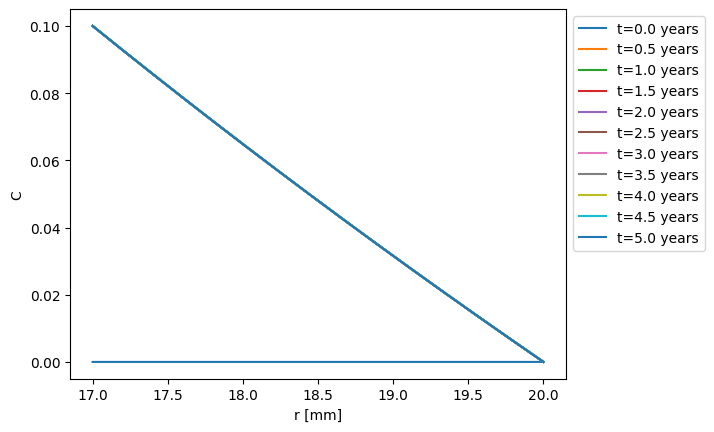

In [24]:
plt.figure()
for i in range(0,nt+1,100):
    plt.plot(r*1e3,H[:,i],label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel('C') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

2. Concentración vs tiempo para cada radio

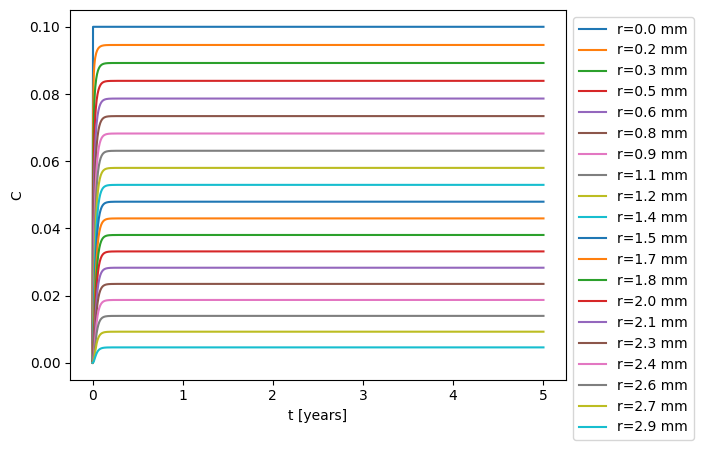

In [25]:
plt.figure()
for i in range(0,n,100):
    plt.plot(t[:],H[i,:],label=f'r={i*dr*1e3:.1f} mm') 
plt.xlabel('t [years]')
plt.ylabel('C')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


3. Flujo vs radio para cada tiempo

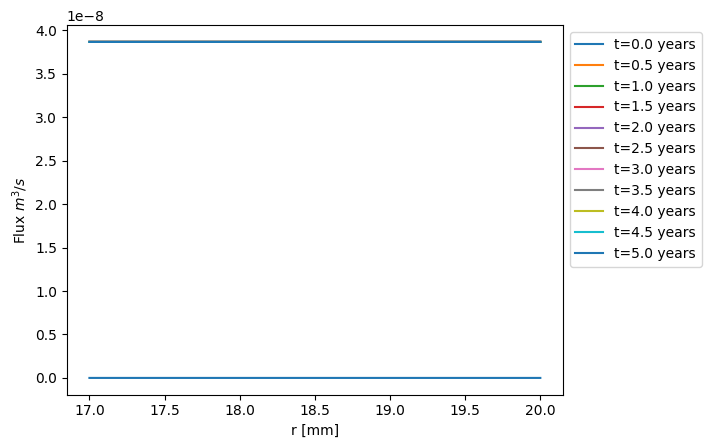

In [26]:
plt.figure()
for i in range(0,nt+1,100):
    plt.plot(r*1e3,Hflux[:,i],label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel('Flux $m^3/s$') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

4. Flujo en radio interno y externo vs tiempo

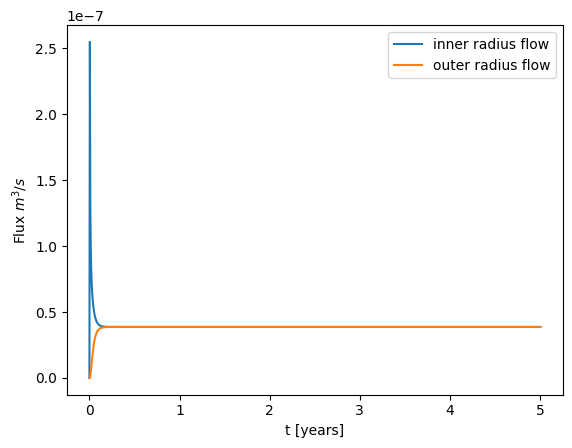

In [27]:
plt.figure()
plt.plot(t,Hflux[0,:],label=f'inner radius flow') 
plt.plot(t,Hflux[n-1,:],label=f'outer radius flow') 
plt.xlabel('t [years]')
plt.ylabel('Flux $m^3/s$') 
plt.legend(loc='upper right')

5. Desplazamiento vertical vs radio para cada tiempo

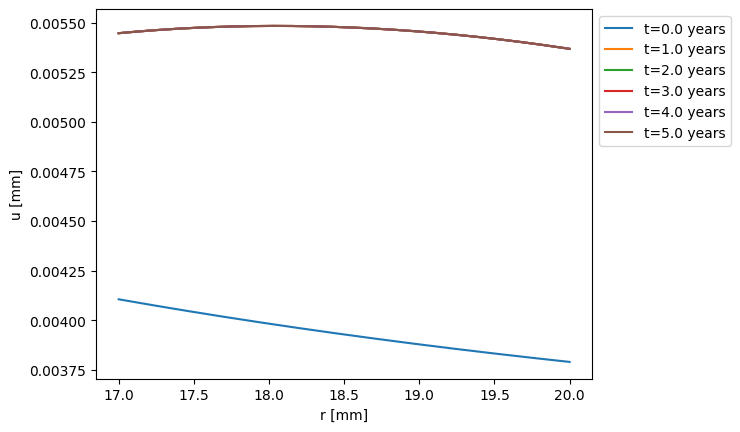

In [28]:
plt.figure()
for i in range(0,nt+1,200):
    plt.plot(r*1e3,HDisp[:,i]*1e3,label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel('u [mm]') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

6. sigma_r vs radio para cada tiempo

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_15420\4256875565.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_r$ [Pa]')


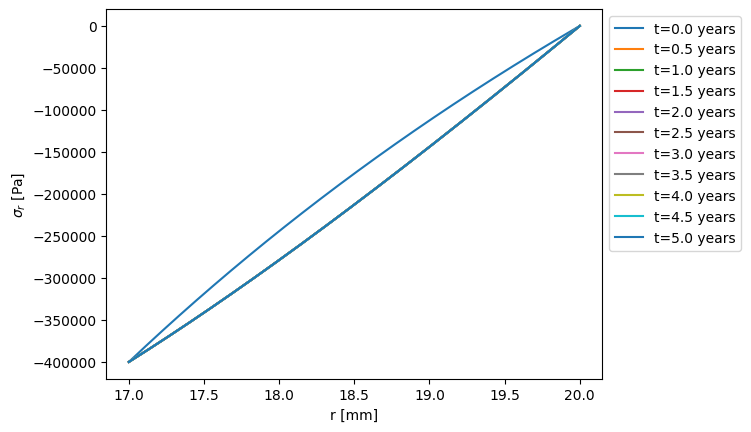

In [29]:
plt.figure()
for i in range(0,nt+1,100):
    plt.plot(r*1e3,HStress_r[:,i],label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel('$\sigma_r$ [Pa]') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

7. sigma_t vs radio para cada tiempo

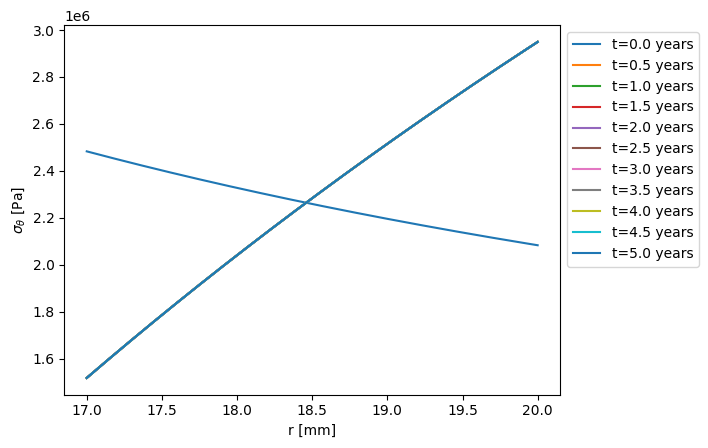

In [30]:
plt.figure()
for i in range(0,nt+1,100):
    plt.plot(r*1e3,HStress_t[:,i],label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel(r'$\sigma_\theta$ [Pa]')  
#https://stackoverflow.com/questions/10370760/matplotlib-axis-label-theta-does-not-work-theta-does
#If you specify that the string is raw text (a r before the quotation mark), it works
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

8. epsilon_r vs radio para cada tiempo

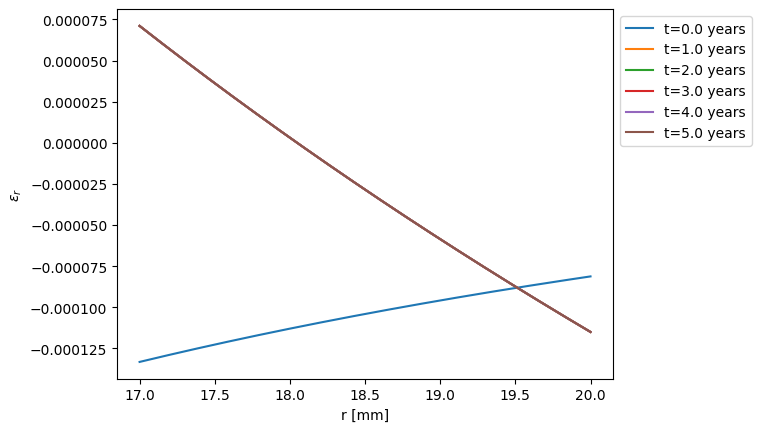

In [31]:
plt.figure()
for i in range(0,nt+1,200):
    plt.plot(r*1e3,HStrain_r[:,i],label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel(r'$\epsilon_r$') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

9. epsilon_t vs radio para cada tiempo

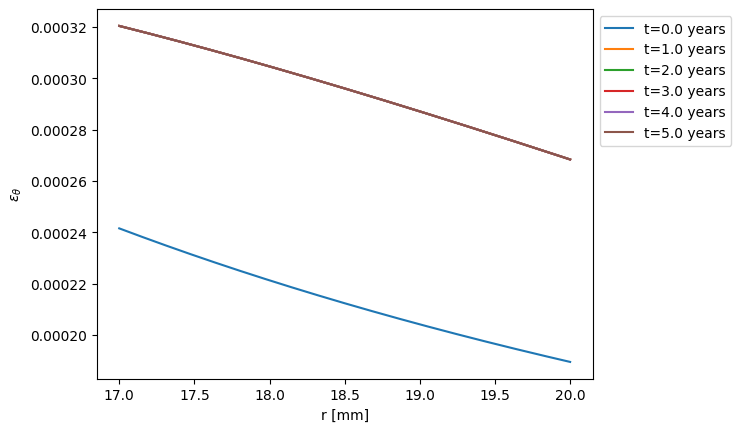

In [32]:
plt.figure()
for i in range(0,nt+1,200):
    plt.plot(r*1e3,HStrain_t[:,i],label=f't={i*dt:.1f} years') 
plt.xlabel('r [mm]')
plt.ylabel(r'$\epsilon_\theta$') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))